In [116]:
%load_ext line_profiler
import numpy as np
import matplotlib.pyplot as plt
from som import *
from matplotlib import animation, rc
from matplotlib import colors
from IPython.display import HTML
import math
import sklearn.datasets
import scipy.stats

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# 2D Features
## Plotting routines

In [81]:
def get_x_y(som):
    '''
        Extracts x and y coords on a 2D som.
    '''
    x = som.som[:,:,0].flatten()
    y = som.som[:,:,1].flatten()
    return x,y

def plot_2D_som(som):
    x,y = get_x_y(som)
    plt.scatter(x,y)
    plt.show()

def update_plot(i, frames, scat):
    scat.set_offsets(frames[i])
    return [scat]    

def movie_2D_som(frames):
    '''
        Gets HTML5 video out of frames.
    '''

    nb_frames = len(frames)
    x, y = [],[]

    fig = plt.figure()
    scat = plt.scatter([], [])
    plt.xlim(0,1)
    plt.ylim(0,1)

    ani = animation.FuncAnimation(fig, update_plot, frames=range(nb_frames),
                                  fargs=(frames, scat))
    return ani.to_html5_video()

In [84]:
def plot_som_topology(som):
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16,
            }
    k = 0
    plt.figure(figsize=(20,20))
    x,y = get_x_y(som)
    plt.scatter(x,y)
    for y in range(som.shape[0]):
        for x in range(som.shape[1]):
            x_f,y_f = som.som[y,x]
            plt.text(x_f, y_f, str(k), fontdict=font)
            k += 1
    plt.show()

## Square

In [3]:
square_data = np.random.rand(5000,2)
som_square = SOM(20,20,2)

In [4]:
%%time
frames_square = []
som_square.train(square_data,L0=0.8,lam=1e2,sigma0=10,frames=frames_square)

final t: 300
CPU times: user 2.91 s, sys: 12.4 ms, total: 2.93 s
Wall time: 2.95 s


In [8]:
%%time
print("quantization error:", som_square.quant_err())

quantization error: 0.0432528457322
CPU times: user 10.3 s, sys: 282 ms, total: 10.6 s
Wall time: 10.3 s


In [6]:
HTML(movie_2D_som(frames_square))

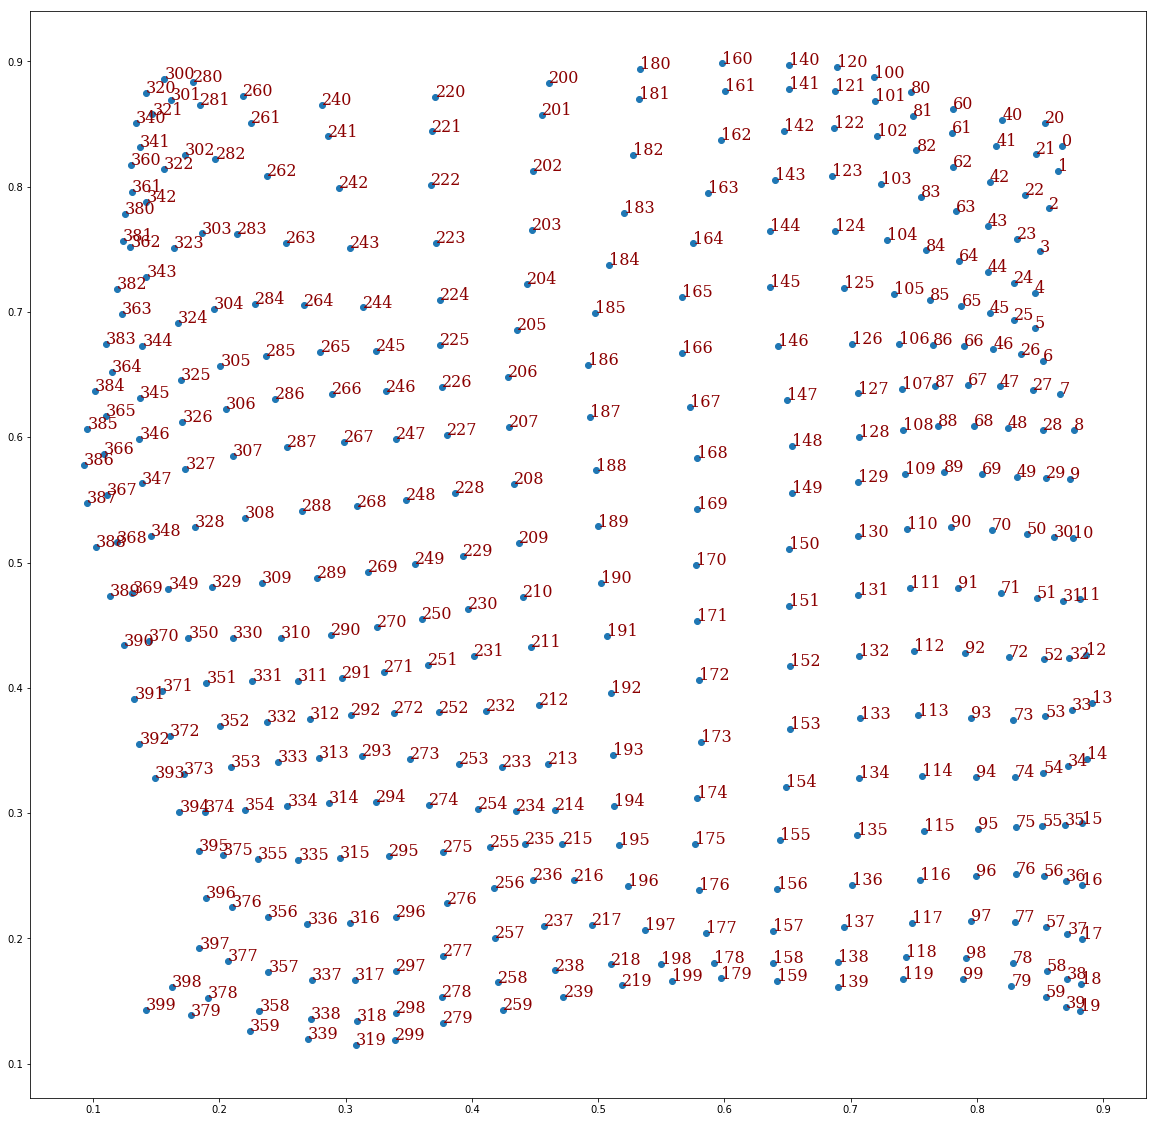

In [86]:
plot_som_topology(som_square)

## Circle

In [71]:
#Reference: https://stackoverflow.com/questions/8487893/generate-all-the-points-on-the-circumference-of-a-circle
def PointsInCircum(r,n=5000):
    return np.array([[math.cos(2*np.pi/n*x)*r+0.5,math.sin(2*np.pi/n*x)*r+0.5] for x in range(0,n+1)])

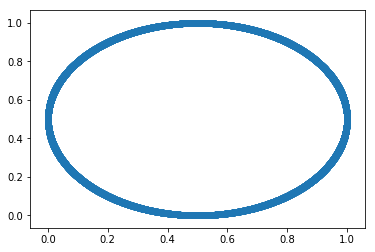

In [78]:
circle_data = PointsInCircum(0.5)
plt.scatter(circle_data[:,0],circle_data[:,1])
plt.show()

In [79]:
%%time
som_circle = SOM(20,20,2)
frames_circle = []
som_circle.train(circle_data,L0=0.8,lam=1e2,sigma0=10,frames=frames_circle)

final t: 300
CPU times: user 2.85 s, sys: 14.4 ms, total: 2.87 s
Wall time: 2.87 s


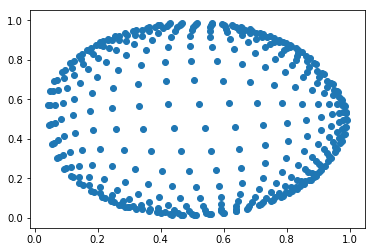

In [88]:
plot_2D_som(som_circle)

In [83]:
HTML(movie_2D_som(frames_circle))

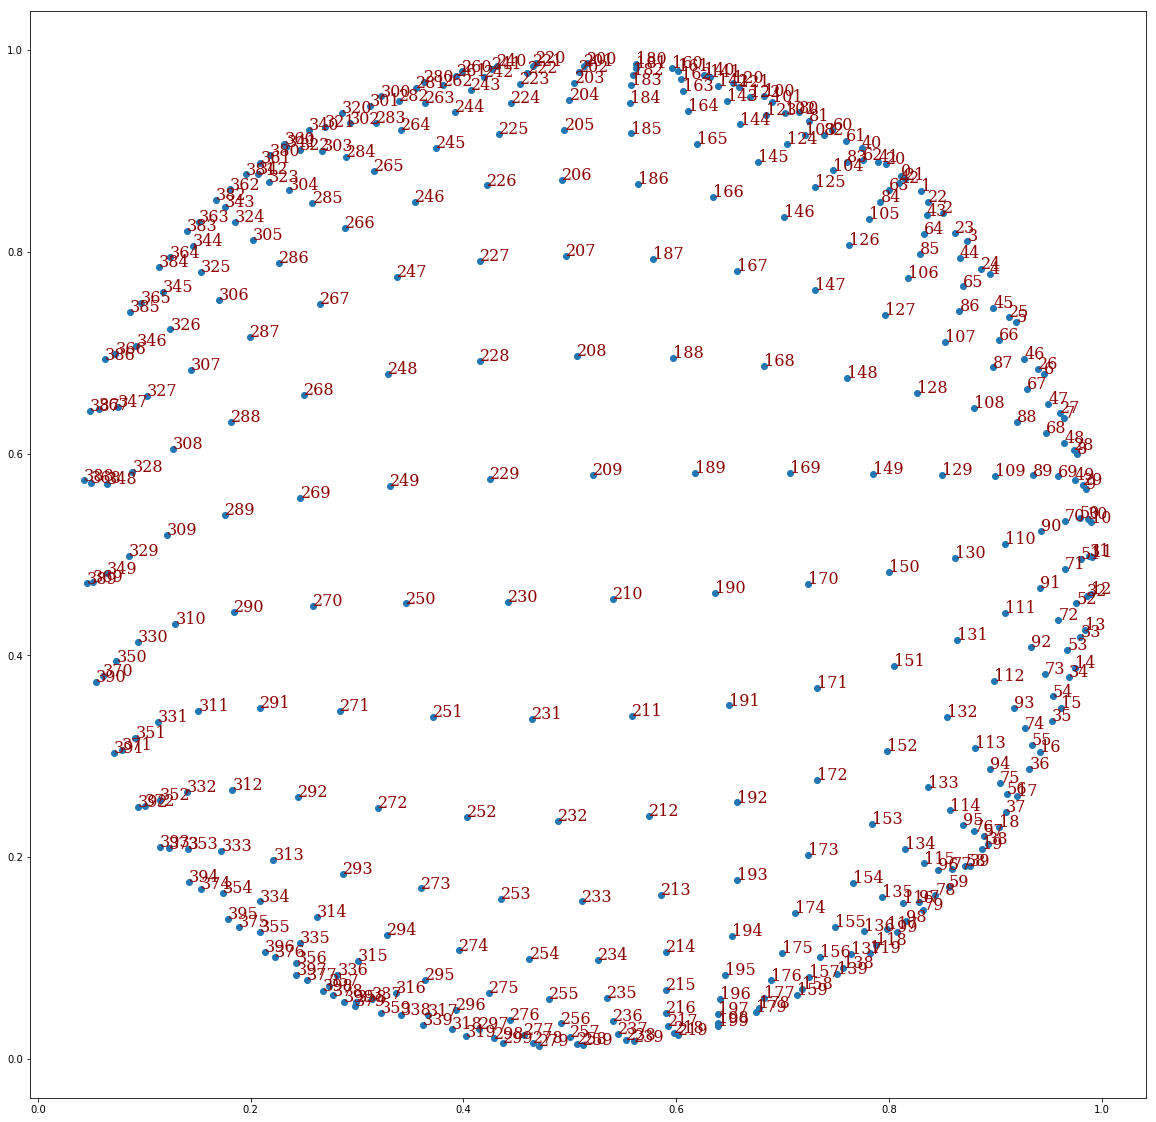

In [87]:
plot_som_topology(som_circle)

# 3D Features: Colors
## Plotting routines

In [112]:
def movie_color_som(frames):
    fig = plt.figure()

    img = frames[0]
    im = plt.imshow(img, animated=True)


    def updatefig(i):
        im.set_array(frames[i])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, interval=400, frames=len(frames)-1, blit=True)
    return ani.to_html5_video()

## Training
### Generating random colors.

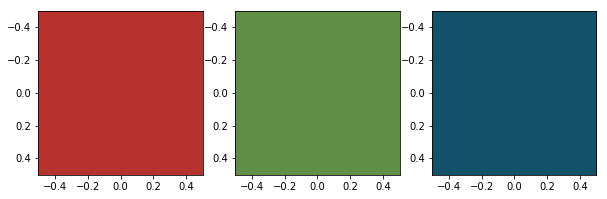

In [103]:
color_data = np.random.rand(3,3)

plt.figure(figsize=(10,8))
for (i,d) in enumerate(color_data):
    plt.subplot(1,3,i+1)
    plt.imshow([[d]])
plt.show()

### Training the SOM

In [104]:
som_color = SOM(40,40,3)
frames_color = []
som_color.train(color_data,L0=0.8,lam=1e2,sigma0=20,frames=frames_color)

final t: 369


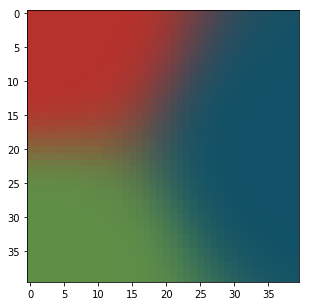

In [108]:
plt.figure(figsize=(5,5))
plt.imshow(frames_color[-1])
plt.show()

In [113]:
HTML(movie_color_som(frames_color))

# Classification
## Routines

In [3]:
def group_targets_per_bmu(dataset,indices,som):
    '''
        Returns a som-shaped array.
        At coordinates (y,x) are stocked all the targets
        of the data for which (y,x) is the BMU in the som.
        dataset: a sk learn dataset.
        indices: indices of the data we're interested in the dataset.
        som: a SOM object, trained on this data.
    '''
    groups = [[[] for x in range(som.shape[1])] for y in range(som.shape[0])]
    for i in indices:
        bmu = som.find_bmu(dataset['data'][i])
        groups[bmu[0]][bmu[1]].append(dataset['target'][i])
    return groups
def majority(l):
    '''
        Returns the most frequent element of an array.
        -1 if the array is empty.
        l: list of integers.
    '''
    if len(l) == 0:
        return -1
    return np.argmax(np.bincount(l))
def get_majority_matrix(targets_per_bmu):
    '''
        Returns the np matrix of majority elements
        in targets_per_bmu.
        targets_per_bmu: array returned by `group_targets_per_bmu`.
    '''
    maj_mat = np.zeros((len(targets_per_bmu),len(targets_per_bmu[0]))).astype(int)
    for y in range(len(targets_per_bmu)):
        for x in range(len(targets_per_bmu[0])):
            maj_mat[y,x] = majority(targets_per_bmu[y][x])
    return maj_mat

def get_entropy_matrix(targets_per_bmu):
    '''
        Returns the np matrix of entropies in
        targets_per_bmu's distributions.
        targets_per_bmu: array returned by `group_targets_per_bmu`.
    '''
    entropy_mat = np.zeros((len(targets_per_bmu),len(targets_per_bmu[0])))
    for y in range(entropy_mat.shape[0]):
        for x in range(entropy_mat.shape[1]):
            entropy_mat[y,x] = scipy.stats.entropy(np.bincount(targets_per_bmu[y][x]),base=3)
    return entropy_mat

In [4]:
# Source: https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)

## Training

In [5]:
iris_data = sklearn.datasets.load_iris()
print(iris_data['DESCR'])

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [48]:
train_percent_per_class = 1
train_0 = np.random.choice(range(50),int(50*train_percent_per_class),replace=False)
train_1 = np.random.choice(range(50),int(50*train_percent_per_class),replace=False)
train_2 = np.random.choice(range(50),int(50*train_percent_per_class),replace=False)
indices_train = np.append(train_0,np.append(50+train_1,100+train_1))
indices_test = list(set(range(150))-set(indices_train))

final t: 231


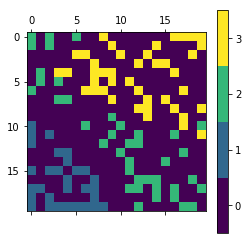

In [134]:
som_iris = SOM(20,20,4)
som_iris.train(iris_data['data'][indices_train],L0=0.8,lam=1e2,sigma0=5)

targets_per_bmu = group_targets_per_bmu(iris_data,indices_train,som_iris)
maj_mat = get_majority_matrix(targets_per_bmu)
img = plt.matshow(maj_mat+1,cmap=discrete_cmap(4))
plt.colorbar(ticks=[range(4)])
plt.clim(-0.5, 4 - 0.5)
plt.show()

In [136]:
bmu_locations_x, bmu_locations_y = [],[]
colors_c = []
c_to_use = ['red','yellow','cyan']
for i in indices_train:
    data_p = iris_data['data'][i]
    bmu = som_iris.find_bmu(data_p)
    bmu_locations_x.append(bmu[1])
    bmu_locations_y.append(bmu[0])
    colors_c.append(c_to_use[maj_mat[bmu]])

In [70]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [76]:
points = np.array(list(zip(bmu_locations_x,bmu_locations_y)))

vor = Voronoi(points)

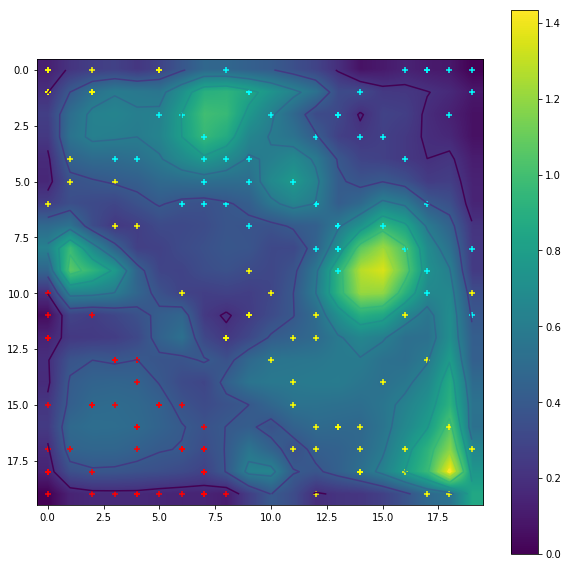

In [137]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
one_adj_U_mat = get_one_adj_U_mat(som_iris)
im = plt.imshow(one_adj_U_mat, interpolation='bilinear')
ax.scatter(bmu_locations_x,bmu_locations_y, marker='+', c=colors_c)
#ax.matshow(maj_mat+1,cmap=discrete_cmap(4))
img = ax.contour(one_adj_U_mat)
fig.colorbar(im)
plt.show()

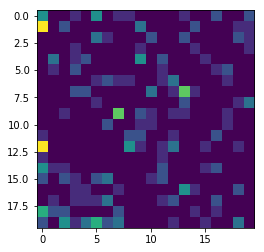

array([[ 4.,  0.,  0.,  1.,  0.,  4.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  2.,  0.,  0.,  2.],
       [ 8.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  2.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  3.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  4.,  0.,  2.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,  1.,  3.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  1.,
         6.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  

In [138]:
plt.imshow(som_iris.hit_score)
plt.show()
som_iris.hit_score

In [12]:
import cv2

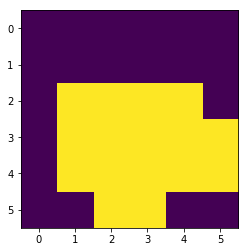

In [32]:
_,th = cv2.threshold(((255*one_adj_U_mat)/np.max(one_adj_U_mat)).astype(np.uint8),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th)
plt.show()

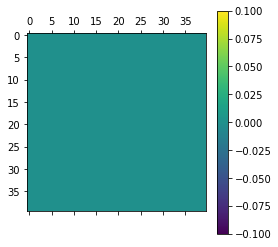

In [40]:
entropy_mat = get_entropy_matrix(targets_per_bmu)
img = plt.matshow(entropy_mat)
plt.colorbar(img)
plt.show()

## Testing
### Classification with SOM

In [46]:
good_answers = 0
mean_entropy = 0.0
for i in indices_test:
    input_vec = iris_data['data'][i]
    target = iris_data['target'][i]
    
    bmu = som_iris.find_bmu(input_vec)
    prediction = maj_mat[bmu]
    mean_entropy += entropy_mat[bmu]
    
    if prediction != target:
        print("wrong:",bmu)
    
    good_answers += (prediction == target)
good_answers /= len(indices_test)
mean_entropy /= len(indices_test)
print("accuracy:",good_answers)
print("mean entropy:",mean_entropy)

wrong: (18, 12)
wrong: (29, 30)
wrong: (28, 37)
wrong: (19, 15)
wrong: (27, 29)
wrong: (18, 33)
wrong: (23, 11)
wrong: (21, 38)
wrong: (25, 18)
wrong: (26, 15)
wrong: (14, 14)
wrong: (22, 32)
wrong: (21, 35)
wrong: (30, 32)
wrong: (17, 34)
wrong: (24, 29)
wrong: (30, 26)
wrong: (24, 21)
wrong: (31, 13)
wrong: (15, 18)
wrong: (23, 20)
wrong: (29, 15)
wrong: (27, 19)
wrong: (23, 21)
wrong: (17, 21)
wrong: (30, 15)
wrong: (21, 15)
wrong: (18, 9)
wrong: (20, 18)
wrong: (28, 13)
accuracy: 0.230769230769
mean entropy: 0.0


### Classification with 1-NN

In [47]:
good_answers = 0
for i in indices_test:
    input_vec = iris_data['data'][i]
    target = iris_data['target'][i]
    
    closest = np.argmin(np.linalg.norm(iris_data['data'][indices_train]-input_vec,axis=1))
    i_closest = indices_train[closest]
    prediction = iris_data['target'][i_closest]
    
    if prediction != target:
        print("wrong:",som_iris.find_bmu(input_vec))
    
    good_answers += (prediction == target)  
good_answers /= len(indices_test)
print("accuracy:",good_answers)

accuracy: 1.0


## U-Matrices
### One Adjacency
One adjacency consist in considering distance 1 cells as neighbours.

In [33]:
def is_valid_unit(som,unit):
    y,x = unit
    return y >= 0 and y < som.shape[0] and x >= 0 and x < som.shape[1]
def one_adj_mean_dist(som,unit):
    y,x = unit
    dirs = [[0,1],[1,0],[0,-1],[-1,0]]
    dists = []
    for dir_ in dirs:
        y_n,x_n = y+dir_[0],x+dir_[0]
        if is_valid_unit(som,(y_n,x_n)):
            dists.append(np.linalg.norm(som.som[unit]-som.som[(y_n,x_n)]))
    return np.array(dists).sum()
def get_one_adj_U_mat(som):
    U_mat = np.zeros(som.shape[:2])
    for y in range(som.shape[0]):
        for x in range(som.shape[1]):
            U_mat[(y,x)] = one_adj_mean_dist(som,(y,x))
    return U_mat

### Euclidian Adjacency

In [48]:
def euclidian_mean_dist(som,unit):
    y,x = unit
    dists = []
    weights = []
    for y_n in range(som.shape[0]):
        for x_n in range(som.shape[1]):
            if (y,x) != (y_n,x_n) and is_valid_unit(som,(y_n,x_n)):
                dists.append(np.linalg.norm(som.som[unit]-som.som[(y_n,x_n)]))
                weights.append(1.0/(np.linalg.norm(np.array((y,x))-np.array((y_n,x_n)))))
    return np.average(np.array(dists),weights=weights)
def get_euclidian_adj_U_mat(som):
    U_mat = np.zeros(som.shape[:2])
    for y in range(som.shape[0]):
        for x in range(som.shape[1]):
            U_mat[(y,x)] =  euclidian_mean_dist(som,(y,x))
    return U_mat

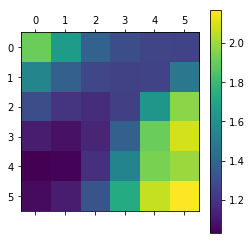

In [49]:
euclidian_U_mat = get_euclidian_adj_U_mat(som_iris)
img = plt.matshow(euclidian_U_mat)
plt.colorbar(img)
plt.show()

In [61]:
digits_data = sklearn.datasets.load_digits()
print(digits_data['DESCR'])

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [76]:
som_digits = SOM(20,20,64)
som_digits.train(digits_data['data'],L0=0.8,lam=1e2,sigma0=5)

final t: 231


In [77]:
targets_per_bmu = group_targets_per_bmu(digits_data,range(len(digits_data['data'])),som_digits)
maj_mat = get_majority_matrix(targets_per_bmu)

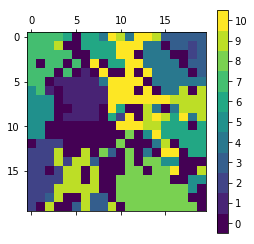

In [78]:
img = plt.matshow(maj_mat+1,cmap=discrete_cmap(11))
plt.colorbar(ticks=[range(11)])
plt.clim(-0.5, 11 - 0.5)
plt.show()

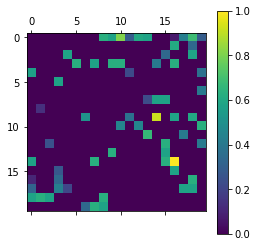

In [79]:
entropy_mat = get_entropy_matrix(targets_per_bmu)
img = plt.matshow(entropy_mat)
plt.colorbar(img)
plt.show()

In [90]:
fig = plt.figure(figsize=(10,10))
one_adj_U_mat = get_one_adj_U_mat(som_digits)
img = plt.matshow(one_adj_U_mat)
fig.colorbar(img)
plt.show()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Figure'